In [1]:
import pandas as pd

In [2]:
from sklearn.datasets import load_wine

In [3]:
wine_data = load_wine()
df = pd.DataFrame(wine_data.data, columns=wine_data.feature_names)
df['target']=wine_data.target



In [4]:
X = df.drop('target',axis=1)


In [5]:
print(X.shape)

(178, 13)


In [6]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [8]:
X_RAW = X.values

X_Transform = StandardScaler().fit_transform(X)

X_Normalise = MinMaxScaler().fit_transform(X)

X_PCA = PCA(n_components=2).fit_transform(X_Transform)

In [9]:
from sklearn.cluster import KMeans, AgglomerativeClustering, MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [13]:
datasets = {
    'RAW': X_RAW,
    'TRANSFORMED': X_Transform,
    'NORMALISED': X_Normalise,
    'PCA': X_PCA
}

results = []

def evaluate(X,labels):
  s = silhouette_score(X,labels)
  ch = calinski_harabasz_score(X,labels)
  db = davies_bouldin_score(X,labels)
  return round(s,4), round(ch,2), round(db,4)

for name, data in datasets.items():
  # k means with k=3
  km = KMeans(n_clusters=3,random_state=42)
  km_labels = km.fit_predict(data)
  s, ch, db = evaluate(data, km_labels)
  results.append([name, 'KMeans (K=3)', s, ch, db])

  # Agglomerative Clustering
  agg = AgglomerativeClustering(n_clusters=3)
  agg_labels = agg.fit_predict(data)
  s, ch, db = evaluate(data, agg_labels)
  results.append([name, 'Agglomerative Clustering', s, ch, db])

  # Mean Shift
  ms = MeanShift()
  ms_labels = ms.fit_predict(data)
  if len(set(ms_labels)) > 1:
    s, ch, db = evaluate(data, ms_labels)
    results.append([name, 'MeanShift', s, ch, db])
  else:
    results.append([name, 'MeanShift', 'Only 1 cluster', 'Only 1 cluster', 'Only 1 cluster'])


results_df = pd.DataFrame(results,columns=['Preprocessing', 'Clustering Method','Silhouette Score', 'Calinski-Harabasz', 'Davies-Bouldin'])

In [14]:
results_df

,Preprocessing,Clustering Method,Silhouette Score,Calinski-Harabasz,Davies-Bouldin
0,RAW,KMeans (K=3),0.5596,497.0,0.5496
1,RAW,Agglomerative Clustering,0.5645,552.85,0.5357
2,RAW,MeanShift,0.5025,454.06,0.5561
3,TRANSFORMED,KMeans (K=3),0.2849,70.94,1.3892
4,TRANSFORMED,Agglomerative Clustering,0.2774,67.65,1.4186
5,TRANSFORMED,MeanShift,0.2245,6.44,1.3201
6,NORMALISED,KMeans (K=3),0.3009,83.35,1.3086
7,NORMALISED,Agglomerative Clustering,0.2948,81.33,1.3183
8,NORMALISED,MeanShift,Only 1 cluster,Only 1 cluster,Only 1 cluster
9,PCA,KMeans (K=3),0.5602,343.95,0.5977


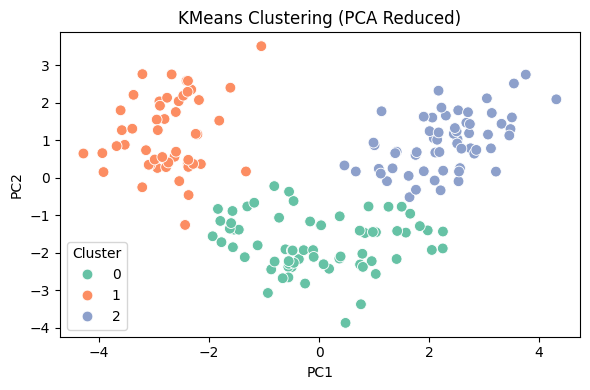

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_clusters(X, labels, title):
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='Set2', s=60)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()

# Example: PCA scatter for KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(X_PCA)
plot_clusters(X_PCA, kmeans_labels, "KMeans Clustering (PCA Reduced)")


<ipython-input-17-300a2128d6d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Silhouette Score'] = filtered_df['Silhouette Score'].astype(float)


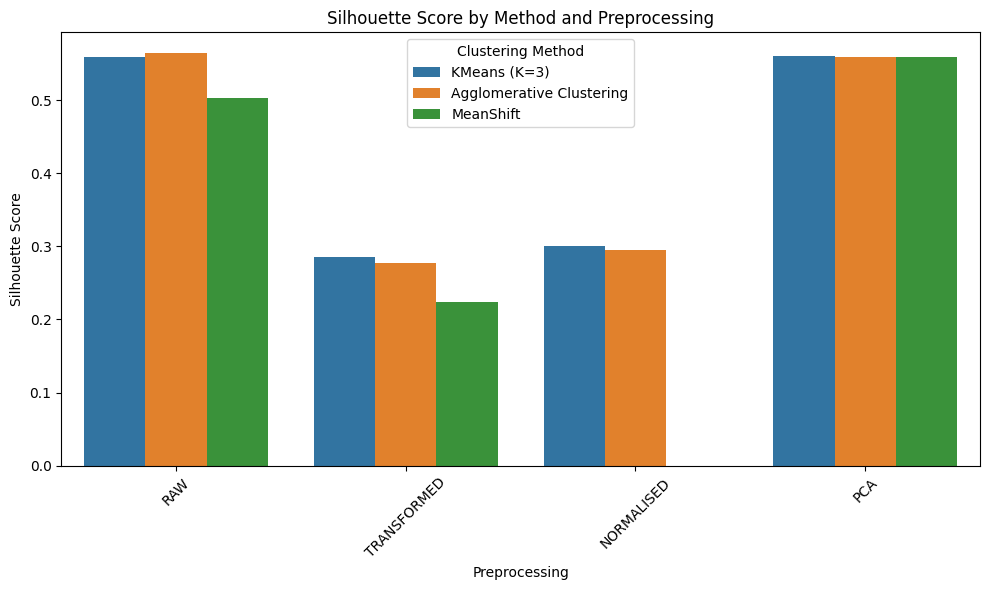

In [17]:
filtered_df = results_df[results_df['Silhouette Score'] != 'Only 1 cluster']

# Convert scores to float
filtered_df['Silhouette Score'] = filtered_df['Silhouette Score'].astype(float)

plt.figure(figsize=(10, 6))
sns.barplot(x='Preprocessing', y='Silhouette Score', hue='Clustering Method', data=filtered_df)
plt.title('Silhouette Score by Method and Preprocessing')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()